
## **Acknowledgement**
 **This is a revised notebook from [Improving CycleGAN - Monet paintings](https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings)**


<p>
<h1><center> Style Transfer</center></h1>
<h2><center> CycleGAN - Hayao Miyazaki and Makoto Shinkai Styles  </center></h2>

### This notebook was created to try several experiments to the original CycleGan (or at least a vey close one) implementation, and see what works or not for this specific task.

#### Experiments (Starting from the original paper architecture):
- Transformer with residual blocks [++]
- Residual connections between Generator and Discriminator [++]
- Not using `InstanceNorm` at the first layer of both generator and discriminator [++]
- Better `InstanceNorm` layer initialization [++]
- Training a lot longer [++]
- Better `Conv` layer initialization [+]
- Residual connection with `Concatenate` instead of `Add` [+]
- Data augmentations (flips, rotations, and crops) [+]
- Discriminator with label smoothing [+]
- Using [external data](https://www.kaggle.com/dimitreoliveira/tfrecords-monet-paintings-256x256) (1193 files) [+-]
- Train on crops [+-]
- Decoder with resize-convolution [+-]
- 9 transformer blocks [+-]
- Patch discriminator [+-]
- Lager batch size [+-]

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CycleGAN

Mounted at /content/drive
/content/drive/MyDrive/CycleGAN


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.9 MB/s eta 0:00:00


## Dependencies

In [3]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## TPU configuration

In [4]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        raise RuntimeError('GPU not found')

    # Assuming there is only one GPU available.
    gpu = gpus[0]
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f'Running on GPU: {gpu.device_type} {gpu.name}')
except RuntimeError as e:
    print(e)
    gpu = None

if gpu:
    print("GPU is available")
else:
    print("GPU is not available")

Running on GPU: GPU /physical_device:GPU:0
GPU is available


# Model parameters

In [5]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 30
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4
AUTO = tf.data.experimental.AUTOTUNE

# Load data

In [6]:
from PIL import Image
import tensorflow as tf
import os
import io

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image):
    feature = {
        'image': _bytes_feature(image),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def process_image_file(file_path):
    img = Image.open(file_path)
    # img = img.resize((256, 256))  # Resize images as needed

    # Save image to byte buffer as JPEG
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')  # Ensure your images are saved as JPEG
    img_byte_arr = img_byte_arr.getvalue()

    return img_byte_arr

def create_tfrecord_file(output_filename, image_dir):
    with tf.io.TFRecordWriter(output_filename) as writer:
        for filename in os.listdir(image_dir):
            file_path = os.path.join(image_dir, filename)
            if file_path.endswith(".jpg") or file_path.endswith(".png"):  # Check for image formats
                image = process_image_file(file_path)
                example = serialize_example(image)
                writer.write(example)

# Example usage:
create_tfrecord_file('shinkai.tfrecord', 'dataset/Shinkai/smooth')
# create_tfrecord_file('train_photo.tfrecord', 'dataset/train_photo')
# create_tfrecord_file('test_photo.tfrecord', 'dataset/test/custom_test')


In [7]:
ANIME_FILENAMES = tf.io.gfile.glob('shinkai.tfrecord')
PHOTO_FILENAMES = tf.io.gfile.glob('train_photo.tfrecord')
TEST_FILENAMES = tf.io.gfile.glob('test_photo.tfrecord')

def count_records_in_tfrecord(file_path):
    count = 0
    for record in tf.data.TFRecordDataset(file_path):
        count += 1
    return count

n_anime_samples = sum(count_records_in_tfrecord(f) for f in ANIME_FILENAMES)
n_photo_samples = sum(count_records_in_tfrecord(f) for f in PHOTO_FILENAMES)

print(f'Anime TFRecord files: {len(ANIME_FILENAMES)}')
print(f'Anime image files: {n_anime_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Anime TFRecord files: 1
Anime image files: 1650
Photo TFRecord files: 1
Photo image files: 6656


# Augmentations

Data augmentation for GANs should be done very carefully, especially for tasks similar to style transfer, if we apply transformations that can change too much the style of the data (e.g. brightness, contrast, saturation) it can cause the generator to do not efficiently learn the base style, so in this case, we are using only spatial transformations like, flips, rotates and crops.

In [8]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)


#     # Random jitter
#     image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

#     # Crops
#     if p_crop > .6: # random crop
#         crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
#         image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
#     elif p_crop > .2: # central crop
#         if p_crop > .5:
#             image = tf.image.central_crop(image, central_fraction=.7)
#         elif p_crop > .35:
#             image = tf.image.central_crop(image, central_fraction=.8)
#         else:
#             image = tf.image.central_crop(image, central_fraction=.9)

    # Train on crops
    # image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])


    return image

## Auxiliar functions

In [9]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    # image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment)
    dataset = dataset.map(normalize_img)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)

    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)

        f = plt.figure(figsize=(12, 12))

        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()

    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)

        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')

        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')

        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')

    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

## Auxiliar functions (model)

Here we the building blocks of our models:
- Encoder block: Apply convolutional filters while also reducing data resolution and increasing features.
- Decoder block: Apply convolutional filters while also increasing data resolution and decreasing features.
- Transformer block: Apply convolutional filters to find relevant data patterns and keeps features constant.

In [10]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]

    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)

    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)

    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear',
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))

#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = L.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)

    return block

# Generator model

The `generator` is responsible for generating images from a specific domain. `CycleGAN` architecture has two generators, in this context we will have one `generator` that will take `photos` and generate `Monet paints`, and the other `generator` will take `Monet paintings` and generate `photos`.

Bellow, we have the architecture of the original `CycleGAN` `generator`, ours have some changes to improve performance on this task.

<center><img src='https://github.com/dimitreOliveira/MachineLearning/blob/master/Kaggle/I%E2%80%99m%20Something%20of%20a%20Painter%20Myself/generator_architecture.png?raw=true' height=250></center>

In [11]:
def generator_fn(height=None, width=None, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)

    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection

    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection

    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)

    return generator

sample_generator = generator_fn()
sample_generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, None, None, 3)]      0         []                            
                                                                                                  
 encoder_block_1 (Conv2D)    (None, None, None, 64)       9408      ['input_image[0][0]']         
                                                                                                  
 re_lu_1 (ReLU)              (None, None, None, 64)       0         ['encoder_block_1[0][0]']     
                                                                                                  
 encoder_block_2 (Conv2D)    (None, None, None, 128)      73728     ['re_lu_1[0][0]']             
                                                                                              

# Discriminator model


The `discriminator` is responsible for differentiating real images from images that have been generated by a `generator` model.

Bellow, we have the architecture of the original `CycleGAN` `discriminator`, again, ours have some changes to improve performance on this task.

<center><img src='https://github.com/dimitreOliveira/MachineLearning/blob/master/Kaggle/I%E2%80%99m%20Something%20of%20a%20Painter%20Myself/discriminator_architecture.png?raw=true' height=550, width=550></center>

In [12]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)

    discriminator = Model(inputs, outputs)

    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 encoder_block_1 (Conv2D)    (None, 128, 128, 64)      3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 encoder_block_2 (Conv2D)    (None, 64, 64, 128)       131072    
                                                                 
 instance_normalization_4 (  (None, 64, 64, 128)       256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                           

# Build model (CycleGAN)

In [13]:
anime_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to anime-esque paintings
photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms anime paintings to be more like photos

anime_discriminator = discriminator_fn(height=None, width=None) # differentiates real anime paintings and generated anime paintings
photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        anime_generator,
        photo_generator,
        anime_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = anime_generator
        self.p_gen = photo_generator
        self.m_disc = anime_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_anime, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to anime back to photo
            fake_anime = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_anime, training=True)

            # anime to photo back to anime
            fake_photo = self.p_gen(real_anime, training=True)
            cycled_anime = self.m_gen(fake_photo, training=True)

            # generating itself
            same_anime = self.m_gen(real_anime, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_anime = self.m_disc(real_anime, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_anime = self.m_disc(fake_anime, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            anime_gen_loss = self.gen_loss_fn(disc_fake_anime)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_anime, cycled_anime, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_anime_gen_loss = anime_gen_loss + total_cycle_loss + self.identity_loss_fn(real_anime, same_anime, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            anime_disc_loss = self.disc_loss_fn(disc_real_anime, disc_fake_anime)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        anime_generator_gradients = tape.gradient(total_anime_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        anime_discriminator_gradients = tape.gradient(anime_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(anime_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(anime_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {'anime_gen_loss': total_anime_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'anime_disc_loss': anime_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

# Loss functions

In [14]:
# Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
def discriminator_loss(real, generated):
    real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

# Generator loss
def generator_loss(generated):
    return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)


# Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

# Identity loss (compares the image with its generator (i.e. photo with photo generator))

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Learning rate schedule

The original `CycleGAN` implementation used a `constant learning rate schedule with a linear decay`, I also found that the linear decay phase seems to be good at making the model more stable at the last epochs, you can check how the `generator` changes in a more conservative rate by the end looking at the `gif` images by the end.

30 total epochs and 416 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 2.4e-06


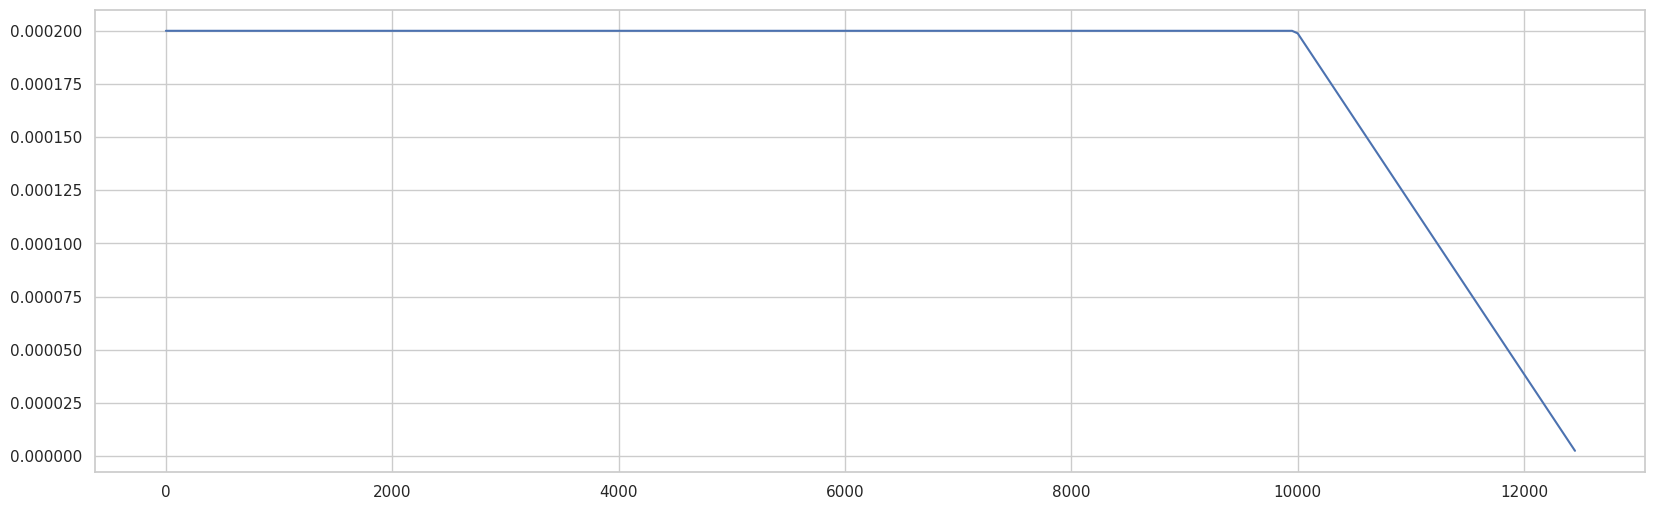

In [15]:
@tf.function
def linear_schedule_with_warmup(step):
    lr_start = 2e-4
    lr_max = 2e-4
    lr_min = 0.0

    steps_per_epoch = int(max(n_anime_samples, n_photo_samples) // BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = int(total_steps * 0.8)

    # Convert step and warmup_steps to float for safe division
    step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(warmup_steps, tf.float32)
    total_steps = tf.cast(total_steps, tf.float32)
    hold_max_steps = tf.cast(hold_max_steps, tf.float32)

    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        remaining_steps = total_steps - step
        decay_steps = total_steps - warmup_steps - hold_max_steps
        lr = lr_max * (remaining_steps / decay_steps)
        if lr_min is not None:
            lr = tf.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_anime_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Train

In [16]:
# Create generators
lr_anime_gen = lambda: linear_schedule_with_warmup(tf.cast(anime_generator_optimizer.iterations, tf.float32))
lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))

current_step = tf.Variable(0, dtype=tf.int64)

def lr_anime_gen():
    return linear_schedule_with_warmup(current_step.value())

def lr_photo_gen():
    return linear_schedule_with_warmup(current_step.value())

anime_generator_optimizer = optimizers.Adam(learning_rate=lr_anime_gen(), beta_1=0.5)
photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen(), beta_1=0.5)


# Create discriminators
lr_anime_disc = lambda: linear_schedule_with_warmup(tf.cast(anime_discriminator_optimizer.iterations, tf.float32))
lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))

anime_discriminator_step = tf.Variable(0, dtype=tf.int64)
photo_discriminator_step = tf.Variable(0, dtype=tf.int64)

def lr_anime_disc():
    return linear_schedule_with_warmup(anime_discriminator_step)

def lr_photo_disc():
    return linear_schedule_with_warmup(photo_discriminator_step)

# Create optimizers using lambda functions for dynamic learning rate adjustments
anime_discriminator_optimizer = optimizers.Adam(learning_rate=lr_anime_disc(), beta_1=0.5)
photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc(), beta_1=0.5)

# Create GAN
gan_model = CycleGan(anime_generator, photo_generator,
                        anime_discriminator, photo_discriminator)

gan_model.compile(m_gen_optimizer=anime_generator_optimizer,
                    p_gen_optimizer=photo_generator_optimizer,
                    m_disc_optimizer=anime_discriminator_optimizer,
                    p_disc_optimizer=photo_discriminator_optimizer,
                    gen_loss_fn=generator_loss,
                    disc_loss_fn=discriminator_loss,
                    cycle_loss_fn=calc_cycle_loss,
                    identity_loss_fn=identity_loss)

In [17]:
# Create dataset
anime_ds = get_dataset(ANIME_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((anime_ds, photo_ds))

photo_ds_eval = get_dataset(TEST_FILENAMES, repeat=False, shuffle=False, batch_size=1)
anime_ds_eval = get_dataset(ANIME_FILENAMES, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=10, anime_path='anime', photo_path='photo'):
        self.num_img = num_img
        self.anime_path = anime_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.anime_path):
            os.makedirs(self.anime_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # anime generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            print(img.shape)
            prediction = anime_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.anime_path}/generated_{i}_{epoch+1}.png')

        # Photo generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

In [18]:
for i, img in enumerate(photo_ds_eval.take(1)):
    print(img.shape)

(1, 256, 256, 3)


In [ ]:
history = gan_model.fit(gan_ds,
                        epochs=EPOCHS,
                        callbacks=[GANMonitor()],
                        steps_per_epoch=(max(n_anime_samples, n_photo_samples)//BATCH_SIZE),
                        verbose=2).history

Epoch 1/30
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
416/416 - 374s - anime_gen_loss: 2.8314 - photo_gen_loss: 3.6805 - anime_disc_loss: 0.6655 - photo_disc_loss: 0.2989 - 374s/epoch - 899ms/step
Epoch 2/30
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
416/416 - 347s - anime_gen_loss: 2.7474 - photo_gen_loss: 3.1215 - anime_disc_loss: 0.6464 - photo_disc_loss: 0.4758 - 347s/epoch - 834ms/step
Epoch 3/30
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
416/416 - 343s - anime_gen_loss: 2.6200 - photo_gen_loss: 3.1481 - anime_disc_loss: 0.6490 - photo_disc_loss: 0.5441 - 343s/epoch - 824ms/step
Epoch 4/30
(1, 256, 256, 3)


We can see the generators progress at each epoch by creating a `gif` that is a generated image at each epoch.

## anime generation GIF

<img src='anime.gif' width=350>

## Photo generation GIF

<img src='photo.gif' width=350>

# Evaluating generator models

Here we are going to evaluate the generator models including how good is the generator cycle, this means that we will get a photo to generate a anime picture from it, then use the generated picture to generate the original photo.

## Photo (input) -> anime (generated) -> Photo (generated)

Here we will do the same process but starting with a anime picture.

## anime (input) -> Photo (generated) -> anime (generated)

# Visualize predictions

A common issue with images generated by GANs is that the often show some undisered artifacts, a very common on is known as "[checkerboard artifacts](https://distill.pub/2016/deconv-checkerboard/)", a good practice is to inspect some of the images to see its quality and if some of these undisered artifacts are present.

## Make predictions

# Submission file

## Output models

In [ ]:
anime_generator.save('anime_generator.h5')
photo_generator.save('photo_generator.h5')
anime_discriminator.save('anime_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/CycleGAN")
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf 'CycleGAN_style_transfer.ipynb' --output '/content/gdrive/MyDrive/CycleGAN/CycleGAN_style_transfer.pdf'